In [1]:
import numpy as np
import os
import sys
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

#import nmrglue as ng
import scipy as sp
import scipy.interpolate as ip
import scipy.optimize as op
import scipy.signal as sg

import tqdm.auto as tqdm

np.random.seed(123)

In [2]:
h = 1.
w = 1.
p = 0.
x = np.linspace(-10., 10., 2001)
ms = np.linspace(0., 1., 101)
lws = np.linspace(0.1, 1., 10)

fig_dir = "../figures/GL_test/"
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [3]:
def gls(x, p, w, m, h):
    
    y = h * (1-m) * np.exp(-4 * np.log(2) * np.square(x-p) / (w ** 2))
    
    y += h * m / (1 + 4 * np.square(x-p) / (w ** 2))
    
    return y

In [4]:
def glp(x, p, w, m, h):
    
    y = h * np.exp(-4 * np.log(2) * (1-m) * np.square(x-p) / (w ** 2))
    
    y /= (1 + 4 * m * np.square(x-p) / (w ** 2))
    
    return y

In [5]:
def voigt(x, p, wg, wl, h, eps=1e-12):
    
    G = np.exp(-4 * np.log(2) * np.square(x-p) / (wg ** 2))
    
    L = 1 / (1 + 4 * np.square(x-p) / (wl ** 2))

    V = sg.fftconvolve(G, L, mode="same")
    
    if np.max(V) < eps:
        return V
    
    V /= np.max(V) / h
    
    return V

In [6]:
w_list = np.linspace(0.1, 1., 100)
hs = np.zeros((w_list.shape[0], w_list.shape[0]))

for i, wg in enumerate(w_list):
    for j, wl in enumerate(w_list):
        
        V = voigt(x, p, wg, wl, h)
        hs[i,j] = np.max(V)

In [7]:
Hs = np.zeros((w_list.shape[0], w_list.shape[0]))
for i, wg in enumerate(w_list):
    for j, wl in enumerate(w_list):
        Hs[i, j] = np.sqrt(wg) * np.sqrt(wl)

In [8]:
def rmse(y1, y2):
    return np.sqrt(np.mean(np.square(y1 - y2)))

In [9]:
def to_minimize(x0, x, y, f):
    
    [p, w, m, h] = x0
    
    y2 = f(x, p, w, m, h)
    
    return rmse(y, y2)

In [10]:
all_res_s = np.zeros((len(lws), len(lws), 4))
all_res_p = np.zeros((len(lws), len(lws), 4))

ys_v = np.zeros((len(lws), len(lws), len(x)))
ys_s = np.zeros((len(lws), len(lws), len(x)))
ys_p = np.zeros((len(lws), len(lws), len(x)))

all_rmses_s = np.zeros((len(lws), len(lws)))
all_rmses_p = np.zeros((len(lws), len(lws)))

for i, wg in enumerate(lws):
    for j, wl in enumerate(lws):
        
        y_v = voigt(x, p, wg, wl, h)
        
        x0 = [0, w, 0.5, h]
        bounds = [(0., 0.), (0., 2.), (0., 1.), (0., 2.)]

        res_s = op.minimize(to_minimize, x0, args=(x, y_v, gls), bounds=bounds,
                          method="Nelder-Mead", options={"xatol": 1e-8, "fatol": 1e-8})
        res_p = op.minimize(to_minimize, x0, args=(x, y_v, glp), bounds=bounds,
                          method="Nelder-Mead", options={"xatol": 1e-8, "fatol": 1e-8})

        y_s = gls(x, *res_s.x)
        y_p = glp(x, *res_p.x)

        all_res_s[i, j] = res_s.x
        all_res_p[i, j] = res_p.x

        ys_v[i, j] = y_v
        ys_s[i, j] = y_s
        ys_p[i, j] = y_p

        all_rmses_s[i, j] = rmse(y_v, y_s)
        all_rmses_p[i, j] = rmse(y_v, y_p)

<ipython-input-3-5233ec704f11>:3: RuntimeWarning: divide by zero encountered in true_divide
  y = h * (1-m) * np.exp(-4 * np.log(2) * np.square(x-p) / (w ** 2))
<ipython-input-3-5233ec704f11>:3: RuntimeWarning: invalid value encountered in true_divide
  y = h * (1-m) * np.exp(-4 * np.log(2) * np.square(x-p) / (w ** 2))
<ipython-input-3-5233ec704f11>:5: RuntimeWarning: divide by zero encountered in true_divide
  y += h * m / (1 + 4 * np.square(x-p) / (w ** 2))
<ipython-input-3-5233ec704f11>:5: RuntimeWarning: invalid value encountered in true_divide
  y += h * m / (1 + 4 * np.square(x-p) / (w ** 2))


In [11]:
X, Y = np.meshgrid(lws, lws)

In [12]:
fdir = fig_dir + "fit_Voigt/"
if not os.path.exists(fdir):
    os.mkdir(fdir)
    
for i, wg in tqdm.tqdm(enumerate(lws), total=len(lws)):
    for j, wl in enumerate(lws):

        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)

        ax.plot(x, ys_v[i, j])
        ax.plot(x, ys_s[i, j])
        ax.plot(x, ys_p[i, j])

        ax.legend(["Voigt", "Fitted GLS", "Fitted GLP"])
        ax.set_xlim(-5., 5.)
        ax.set_ylim(-0.05, 1.05)

        fig.tight_layout()
        plt.savefig(f"{fdir}wg_{wg:.2f}_wl_{wl:.2f}.pdf")
        #plt.show()
        plt.close()

        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)

        ax.plot(x, ys_v[i, j])
        ax.plot(x, ys_s[i, j])
        ax.plot(x, ys_p[i, j])

        ax.legend(["Voigt", "GLS", "Fitted GLP"])
        ax.set_xlim(-5., 5.)
        ax.set_ylim(-0.01, 0.1)

        fig.tight_layout()
        plt.savefig(f"{fdir}wg_{wg:.2f}_wl_{wl:.2f}_zoom.pdf")
        #plt.show()
        plt.close()

  0%|          | 0/10 [00:00<?, ?it/s]

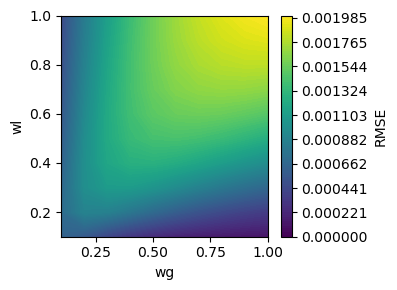

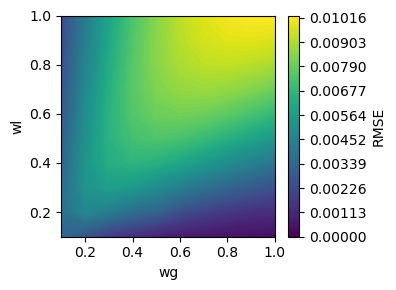

In [13]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

levels = np.linspace(0., np.max(all_rmses_s), 101)
cm = ax.contourf(X, Y, all_rmses_s, levels=levels)
fig.colorbar(cm, label="RMSE")

ax.set_xlabel("wg")
ax.set_ylabel("wl")

fig.tight_layout()
plt.savefig(f"{fdir}rmses_GLS.pdf")
plt.show()
plt.close()

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

levels = np.linspace(0., np.max(all_rmses_p), 101)
cm = ax.contourf(X, Y, all_rmses_p, levels=levels)
fig.colorbar(cm, label="RMSE")

ax.set_xlabel("wg")
ax.set_ylabel("wl")

fig.tight_layout()
plt.savefig(f"{fdir}rmses_GLP.pdf")
plt.show()
plt.close()

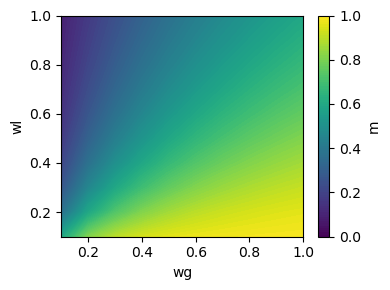

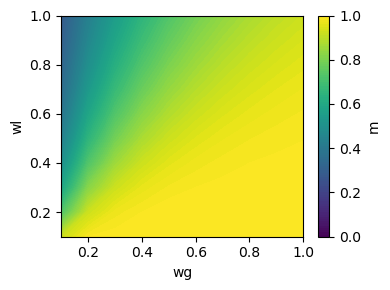

In [14]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

levels = np.linspace(0., 1., 101)
cm = ax.contourf(X, Y, all_res_s[:, :, 2], levels=levels)
fig.colorbar(cm, label="m", ticks=[0., 0.2, 0.4, 0.6, 0.8, 1.])

ax.set_xlabel("wg")
ax.set_ylabel("wl")

fig.tight_layout()
plt.savefig(f"{fdir}ms_GLS.pdf")
plt.show()
plt.close()

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

levels = np.linspace(0., 1., 101)
cm = ax.contourf(X, Y, all_res_p[:, :, 2], levels=levels)
fig.colorbar(cm, label="m", ticks=[0., 0.2, 0.4, 0.6, 0.8, 1.])

ax.set_xlabel("wg")
ax.set_ylabel("wl")

fig.tight_layout()
plt.savefig(f"{fdir}ms_GLP.pdf")
plt.show()
plt.close()

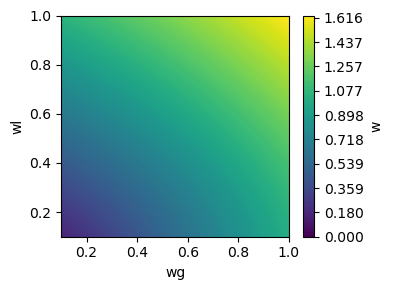

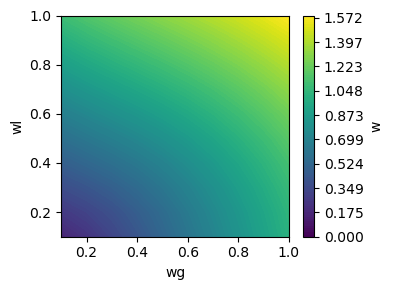

In [15]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

levels = np.linspace(0., np.max(all_res_s[:, :, 1]), 101)
cm = ax.contourf(X, Y, all_res_s[:, :, 1], levels=levels)
fig.colorbar(cm, label="w")

ax.set_xlabel("wg")
ax.set_ylabel("wl")

fig.tight_layout()
plt.savefig(f"{fdir}ws_GLS.pdf")
plt.show()
plt.close()

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

levels = np.linspace(0., np.max(all_res_p[:, :, 1]), 101)
cm = ax.contourf(X, Y, all_res_p[:, :, 1], levels=levels)
fig.colorbar(cm, label="w")

ax.set_xlabel("wg")
ax.set_ylabel("wl")

fig.tight_layout()
plt.savefig(f"{fdir}ws_GLP.pdf")
plt.show()
plt.close()

In [16]:
all_res = []
ys_s = []
ys_p = []
all_rmses = []

for i, m in tqdm.tqdm(enumerate(ms), total=len(ms)):
    
    y_s = gls(x, p, w, m, h)
    
    x0 = [0, w, m, h]
    bounds = [(0., 0.), (0., 2.), (0., 1.), (0., 2.)]
    
    res = op.minimize(to_minimize, x0, args=(x, y_s, glp), bounds=bounds,
                      method="Nelder-Mead", options={"xatol": 1e-8, "fatol": 1e-8})
    
    y_p = glp(x, *res.x)
    
    all_res.append(res.x)
    
    ys_s.append(y_s)
    ys_p.append(y_p)
    
    all_rmses.append(rmse(y_s, y_p))
all_res = np.array(all_res)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

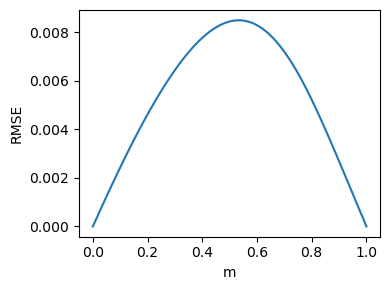

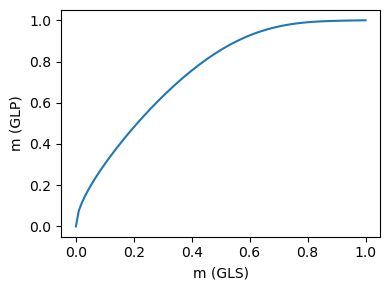

In [17]:
fdir = fig_dir + "fit_GLS/"
if not os.path.exists(fdir):
    os.mkdir(fdir)
    
for m_s, y_s, y_p in tqdm.tqdm(zip(ms, ys_s, ys_p), total=len(ms)):
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    ax.plot(x, y_s)
    ax.plot(x, y_p)
    
    ax.legend(["GLS", "Fitted GLP"])
    ax.set_xlim(-5., 5.)
    ax.set_ylim(-0.05, 1.05)
    
    fig.tight_layout()
    plt.savefig(f"{fdir}m_{m_s:.2f}.pdf")
    #plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    ax.plot(x, y_s)
    ax.plot(x, y_p)
    
    ax.legend(["GLS", "Fitted GLP"])
    ax.set_xlim(-5., 5.)
    ax.set_ylim(-0.01, 0.1)
    
    fig.tight_layout()
    plt.savefig(f"{fdir}m_{m_s:.2f}_zoom.pdf")
    #plt.show()
    plt.close()
    
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(ms, all_rmses)

ax.set_xlabel("m")
ax.set_ylabel("RMSE")

fig.tight_layout()
plt.savefig(f"{fdir}rmses.pdf")
plt.show()
plt.close()

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(ms, all_res[:, 2])

ax.set_xlabel("m (GLS)")
ax.set_ylabel("m (GLP)")

fig.tight_layout()
plt.savefig(f"{fdir}ms.pdf")
plt.show()
plt.close()

In [18]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
fig_gls, = ax.plot(x, y_s, lw=1.)
fig_glp, = ax.plot(x, y_p, lw=1.)

ax.legend(["GLS", "Fitted GLP"])

fig.tight_layout()

def init():
    ax.set_xlim(-5., 5.)
    ax.set_ylim(-0.05, 1.05)
    return fig,

def update(k):
    fig_gls.set_data(x, ys_s[k])
    fig_glp.set_data(x, ys_p[k])
    return fig,

A = anm.FuncAnimation(fig, update, init_func=init, frames=len(ms), interval=50, blit=True)

A.save(f"{fdir}anim.mp4", dpi=300)

plt.close()

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
fig_gls, = ax.plot(x, y_s, lw=1.)
fig_glp, = ax.plot(x, y_p, lw=1.)

ax.legend(["GLS", "Fitted GLP"])

fig.tight_layout()

def init():
    ax.set_xlim(-5., 5.)
    ax.set_ylim(-0.01, 0.1)
    return fig,

def update(k):
    fig_gls.set_data(x, ys_s[k])
    fig_glp.set_data(x, ys_p[k])
    return fig,

A = anm.FuncAnimation(fig, update, init_func=init, frames=len(ms), interval=50, blit=True)

A.save(f"{fdir}anim_zoom.mp4", dpi=300)

plt.close()

In [19]:
all_res = []
ys_p = []
ys_s = []
all_rmses = []

for i, m in tqdm.tqdm(enumerate(ms), total=len(ms)):
    
    y_p = glp(x, p, w, m, h)
    
    x0 = [0, w, m, h]
    bounds = [(0., 0.), (0., 2.), (0., 1.), (0., 2.)]
    
    res = op.minimize(to_minimize, x0, args=(x, y_p, gls), bounds=bounds,
                      method="Nelder-Mead", options={"xatol": 1e-8, "fatol": 1e-8})
    
    y_s = gls(x, *res.x)
    
    all_res.append(res.x)
    
    ys_p.append(y_p)
    ys_s.append(y_s)
    
    all_rmses.append(rmse(y_p, y_s))
all_res = np.array(all_res)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

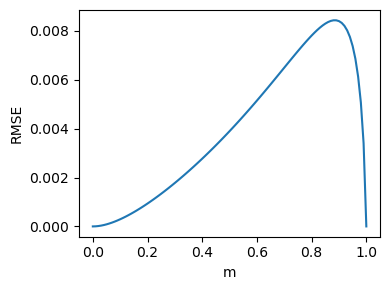

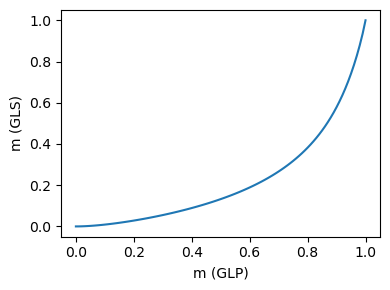

In [20]:
fdir = fig_dir + "fit_GLP/"
if not os.path.exists(fdir):
    os.mkdir(fdir)
for m_s, y_s, y_p in tqdm.tqdm(zip(ms, ys_s, ys_p), total=len(ms)):
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    ax.plot(x, y_p)
    ax.plot(x, y_s)
    
    ax.legend(["GLP", "Fitted GLS"])
    ax.set_xlim(-5., 5.)
    ax.set_ylim(-0.05, 1.05)
    
    fig.tight_layout()
    plt.savefig(f"{fdir}m_{m_s:.2f}.pdf")
    #plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    ax.plot(x, y_p)
    ax.plot(x, y_s)
    
    ax.legend(["GLP", "Fitted GLS"])
    ax.set_xlim(-5., 5.)
    ax.set_ylim(-0.01, 0.1)
    
    fig.tight_layout()
    plt.savefig(f"{fdir}m_{m_s:.2f}_zoom.pdf")
    #plt.show()
    plt.close()
    
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(ms, all_rmses)

ax.set_xlabel("m")
ax.set_ylabel("RMSE")

fig.tight_layout()
plt.savefig(f"{fdir}rmses.pdf")
plt.show()
plt.close()

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(ms, all_res[:, 2])

ax.set_xlabel("m (GLP)")
ax.set_ylabel("m (GLS)")

fig.tight_layout()
plt.savefig(f"{fdir}ms.pdf")
plt.show()
plt.close()

In [21]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
fig_glp, = ax.plot(x, y_p, lw=1.)
fig_gls, = ax.plot(x, y_s, lw=1.)

ax.legend(["GLP", "Fitted GLS"])

fig.tight_layout()

def init():
    ax.set_xlim(-5., 5.)
    ax.set_ylim(-0.05, 1.05)
    return fig,

def update(k):
    fig_glp.set_data(x, ys_p[k])
    fig_gls.set_data(x, ys_s[k])
    return fig,

A = anm.FuncAnimation(fig, update, init_func=init, frames=len(ms), interval=50, blit=True)

A.save(f"{fdir}anim.mp4", dpi=300)

plt.close()

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
fig_glp, = ax.plot(x, y_p, lw=1.)
fig_gls, = ax.plot(x, y_s, lw=1.)

ax.legend(["GLP", "Fitted GLS"])

fig.tight_layout()

def init():
    ax.set_xlim(-5., 5.)
    ax.set_ylim(-0.01, 0.1)
    return fig,

def update(k):
    fig_glp.set_data(x, ys_p[k])
    fig_gls.set_data(x, ys_s[k])
    return fig,

A = anm.FuncAnimation(fig, update, init_func=init, frames=len(ms), interval=50, blit=True)

A.save(f"{fdir}anim_zoom.mp4", dpi=300)

plt.close()